Import Library

In [ ]:
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers
from sklearn.metrics import classification_report

Access Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/gdrive
Mounted at /content/drive


Load Data

In [ ]:
# Create Dataset Path
dataset_path = '/content/drive/MyDrive/Semester 4/Project/RM'

# Create Dataset Directory
data_dir = pathlib.Path(dataset_path)

# Data Preprocessing

Split Dataset Into 80% Train Set and 20% Validation Set

In [ ]:
train_ds, valid_ds = tf.keras.utils.image_dataset_from_directory(
  directory = data_dir,
  batch_size = 16,
  image_size = (224, 224),
  labels = 'inferred',
  label_mode = 'categorical',
  validation_split = 0.2,
  seed = 123,
  subset = 'both'
)

Found 1575 files belonging to 2 classes.
Using 1260 files for training.
Using 315 files for validation.


Get Classes/Labels on Dataset

In [ ]:
class_name = train_ds.class_names
print(class_name)

['Edible', 'Poisonous']


Show Images on Train Set

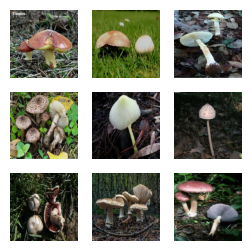

In [ ]:
plt.figure(figsize = (3, 3))

for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        # plt.title(class_name[labels[i]])
        plt.axis('off')

Split Validation Set Into 10% Test Set and 10% Validation Set

In [ ]:
test_ds = valid_ds.shard(num_shards = 2, index = 0)
valid_ds = valid_ds.shard(num_shards = 2, index = 1)

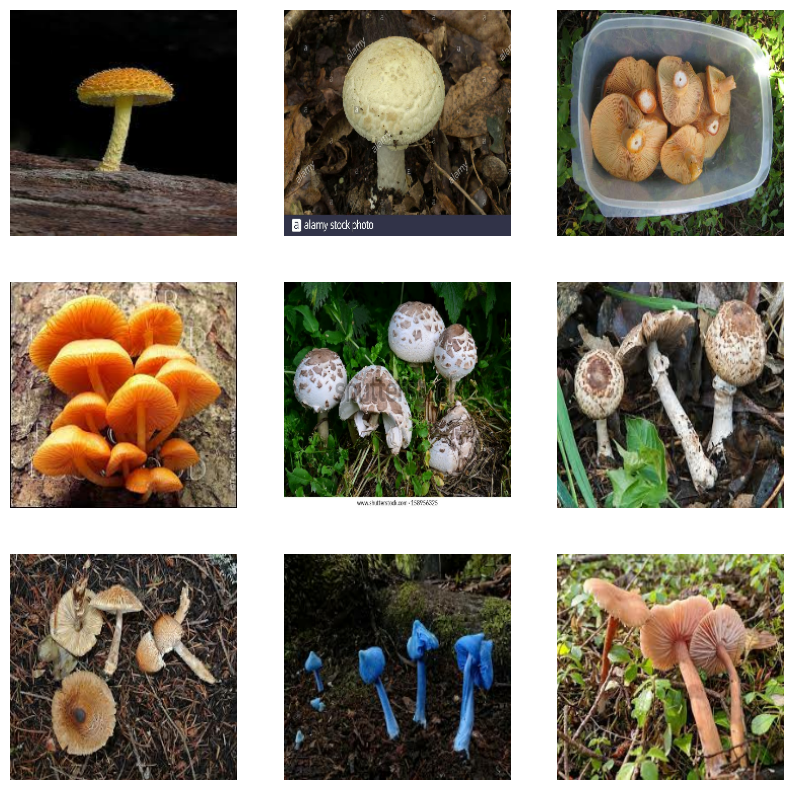

In [ ]:
plt.figure(figsize = (10, 10))

for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        # plt.title(class_name[labels[i]])
        plt.axis('off')

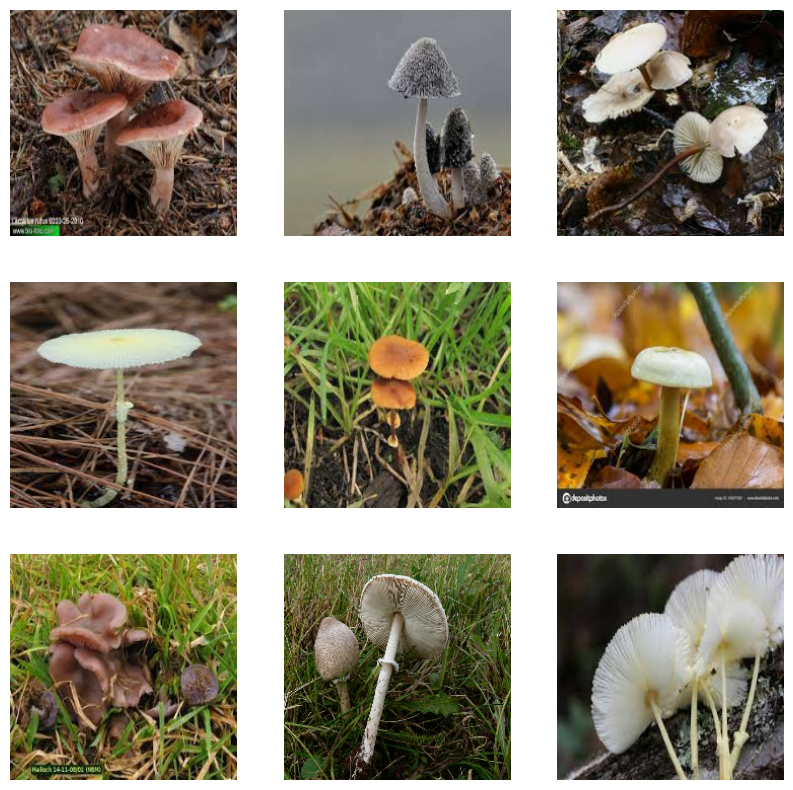

In [ ]:
plt.figure(figsize = (10, 10))

for images, labels in valid_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        # plt.title(class_name[labels[i]])
        plt.axis('off')

Data Optimization

In [ ]:
train_ds = train_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(tf.data.AUTOTUNE)
valid_ds = valid_ds.cache().prefetch(tf.data.AUTOTUNE)

Data Augmentation

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal_and_vertical', input_shape = (224, 224, 3)),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
])

Show The Data Augmented Images

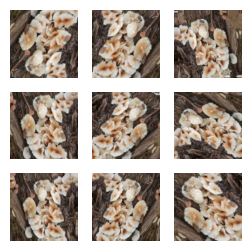

In [ ]:
plt.figure(figsize = (3, 3))

for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype('uint8'))
        plt.axis('off')

# Modeling

Build The Model Using Convolutional Neural Network

In [ ]:
# Build Model
model = models.Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(16, (3,3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D(),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(len(class_name), activation = 'softmax')
])

# Summary Model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                  

Model Configuration

In [ ]:
model.compile(
    optimizer = tf.keras.optimizers.SGD(learning_rate = 0.01),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

Train Model

In [ ]:
history = model.fit(
    train_ds,
    validation_data = valid_ds,
    epochs = 50,
    callbacks = tf.keras.callbacks.EarlyStopping(verbose = 1, patience = 5, restore_best_weights = True)
)

Epoch 1/50
79/79 [==============================] - 49s 493ms/step - loss: 0.6888 - accuracy: 0.5405 - val_loss: 0.6836 - val_accuracy: 0.5613
Epoch 2/50
79/79 [==============================] - 2s 26ms/step - loss: 0.6860 - accuracy: 0.5611 - val_loss: 0.6766 - val_accuracy: 0.6258
Epoch 3/50
79/79 [==============================] - 2s 25ms/step - loss: 0.6762 - accuracy: 0.5706 - val_loss: 0.6691 - val_accuracy: 0.6258
Epoch 4/50
79/79 [==============================] - 2s 24ms/step - loss: 0.6753 - accuracy: 0.5794 - val_loss: 0.6673 - val_accuracy: 0.6000
Epoch 5/50
79/79 [==============================] - 2s 27ms/step - loss: 0.6658 - accuracy: 0.5929 - val_loss: 0.6568 - val_accuracy: 0.6258
Epoch 6/50
79/79 [==============================] - 2s 26ms/step - loss: 0.6631 - accuracy: 0.5929 - val_loss: 0.6473 - val_accuracy: 0.6387
Epoch 7/50
79/79 [==============================] - 2s 24ms/step - loss: 0.6579 - accuracy: 0.5905 - val_loss: 0.6406 - val_accuracy: 0.6516
Epoch 8/50


# Prediction

Predict Data and Take Predicted Label

In [ ]:
# Predict Test Set
y_pred = model.predict(test_ds)

# Take Predicted Label with The Largest Probability
y_pred = tf.argmax(y_pred, axis = 1)

10/10 [==============================] - 46s 443ms/step


Take Actual Label from Data

In [ ]:
# Create An Empty Array to Store Actual Label
y_true = []

# Take Actual Label
for images, labels in test_ds:
    y_true.extend(labels.numpy())

# Convert to Tensor
y_true = tf.stack(y_true)

# Take Actual Label with The Largest Probability
y_true = tf.argmax(y_true, axis = 1)

Convert to Label

In [ ]:
def convert_to_label(labels):
  real_labels = []

  for label in labels:
    real_labels.append(class_name[label.numpy()])

  return real_labels

In [ ]:
y_pred = convert_to_label(y_pred)
y_true = convert_to_label(y_true)

for idx in range(len(y_pred)):
  print(f'Data ke-{idx} \nTrue Label : {y_true[idx]}\tPredicted Label : {y_pred[idx]}')

Data ke-0 
True Label : Poisonous	Predicted Label : Poisonous
Data ke-1 
True Label : Poisonous	Predicted Label : Poisonous
Data ke-2 
True Label : Edible	Predicted Label : Edible
Data ke-3 
True Label : Poisonous	Predicted Label : Poisonous
Data ke-4 
True Label : Edible	Predicted Label : Poisonous
Data ke-5 
True Label : Edible	Predicted Label : Poisonous
Data ke-6 
True Label : Poisonous	Predicted Label : Poisonous
Data ke-7 
True Label : Poisonous	Predicted Label : Poisonous
Data ke-8 
True Label : Edible	Predicted Label : Edible
Data ke-9 
True Label : Poisonous	Predicted Label : Poisonous
Data ke-10 
True Label : Poisonous	Predicted Label : Poisonous
Data ke-11 
True Label : Edible	Predicted Label : Edible
Data ke-12 
True Label : Edible	Predicted Label : Edible
Data ke-13 
True Label : Poisonous	Predicted Label : Poisonous
Data ke-14 
True Label : Edible	Predicted Label : Edible
Data ke-15 
True Label : Edible	Predicted Label : Edible
Data ke-16 
True Label : Poisonous	Predicted

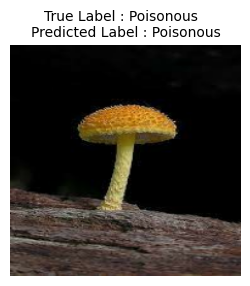

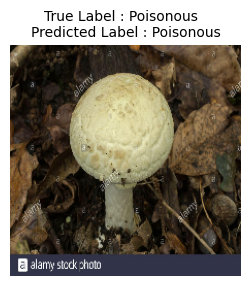

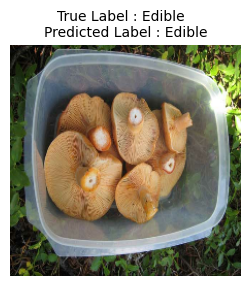

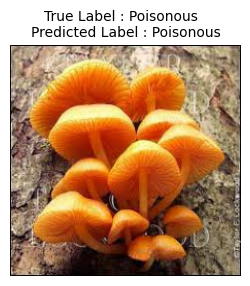

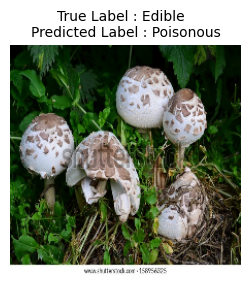

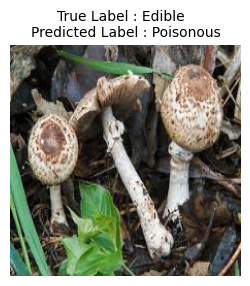

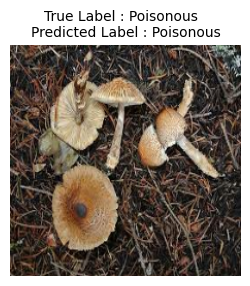

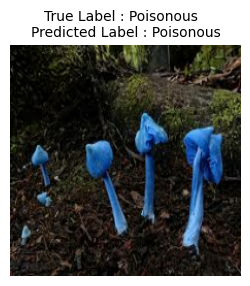

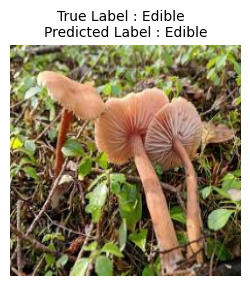

In [ ]:
for images, labels in test_ds.take(1):
  for idx in range(9):
    plt.figure(figsize = (3, 3))
    plt.imshow(images[idx].numpy().astype('uint8'))

    label = f'True Label : {y_true[idx]}  \nPredicted Label : {y_pred[idx]}'
    plt.title(label = label, fontsize = 10)
    plt.axis('off')

Accuracy of Prediction

In [ ]:
# Convert to Numpy Array
y_pred = np.array(y_pred)
y_true = np.array(y_true)

accuracy = np.mean(y_pred == y_true)
print('Prediction Accuracy :', accuracy)

Prediction Accuracy : 0.6375


# Evaluate Model

Classification Report

In [ ]:
print('CLASSIFICATION REPORT')
print(classification_report(y_true, y_pred))

CLASSIFICATION REPORT
              precision    recall  f1-score   support

      Edible       0.70      0.43      0.53        77
   Poisonous       0.61      0.83      0.70        83

    accuracy                           0.64       160
   macro avg       0.66      0.63      0.62       160
weighted avg       0.65      0.64      0.62       160



Plot Accuracy and Loss

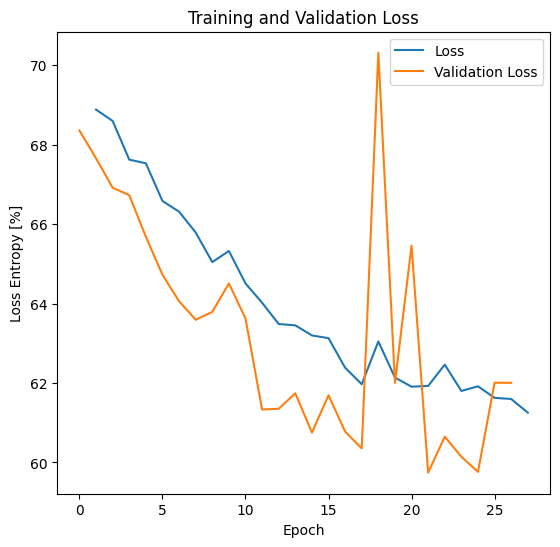

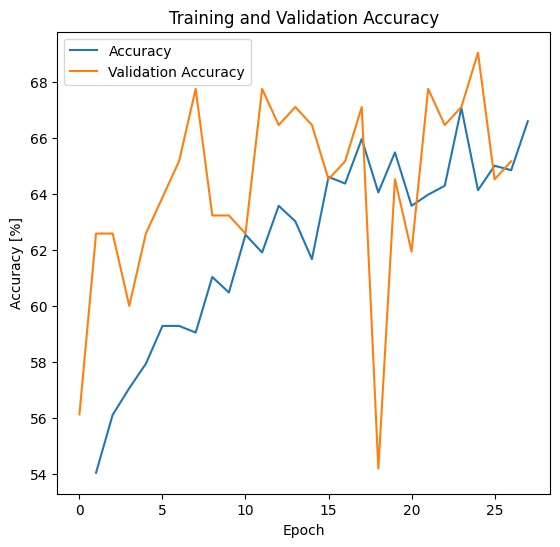

In [ ]:
metrics = history.history

epochs = range(1, len(metrics['accuracy']) + 1)

# Loss
plt.figure(figsize = (14, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, 100 * np.array(metrics['loss']), 100 * np.array(metrics['val_loss']))
plt.title('Training and Validation Loss')
plt.legend(['Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss Entropy [%]')
plt.show()

# Accuracy
plt.figure(figsize = (14, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, 100 * np.array(metrics['accuracy']), 100 * np.array(metrics['val_accuracy']))
plt.title('Training and Validation Accuracy')
plt.legend(['Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')
plt.show()